数据集信息如下：

```
origin_dataset
└── train.csv
```

对 `train.csv` 划分训练集与测试集进行训练

In [3]:
!pip install jieba

In [1]:
#导入必要的包

#计算与可视化
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#评估指标、编码与模型
from  sklearn.metrics import accuracy_score,  auc, confusion_matrix, roc_auc_score, classification_report,cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.optimize import fmin_powell

from sklearn.model_selection import train_test_split

#分词包
import jieba

In [2]:
#计算得分
import time
import math
from sklearn.metrics import log_loss
import numpy as np

def logscore(y_true, y_pred, l):
    """
    :param y_true:
    :param y_pred:
    :param l:
    :return:
    """
    eps = 1e-15
    
    y_true = np.array(y_true).astype(np.float)
    y_pred = np.array(y_pred).astype(np.float)
    assert (len(y_true) and len(y_true) == len(y_pred))

    p = np.clip(y_pred, eps, 1 - eps)
    a = float(np.sum(- y_true * np.log(p) - (1 - y_true) * np.log(1 - p)))
    print("log_loss:", a)
    score = (1 - (a / l)) * 100

    return score


def get_score(tree, test_label, test_data):
    time_start = time.time()  #time.time()
    y_pred  = tree.predict(test_data)
    #print(type(test_label))
    y_pred_proba = tree.predict_proba(test_data)
    
    #print(y_pred_proba[:,1])
    #计算模型推理时间
    time_end = time.time()
    run_time = time_end - time_start   #单位是秒
    
    log_loss =  logscore(test_label, y_pred_proba[:,1], test_data.shape[0])
    #log_loss =  logscore(test_label, y_pred, test_data.shape[0])
    
    print(log_loss)
    #设置运行时间分数
    tr = 1
    if run_time < 600 and run_time >=360 :
        tr = 3
    elif run_time <360 and run_time >= 120:
        tr = 5
    elif run_time < 120 and run_time >=60:
        tr = 7
    else:
        tr = 10
    
    print("tr:", tr)
    #计算最终得分
    score = log_loss * 0.9 + tr 
    
    return score 

## baseline模型

In [3]:
# 导入数据集 wuhu-md5-data
 
import wfio
_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

In [4]:
#第一步：读取数据
#df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')


#第二步：删除object类型的字段特征
for f in df.columns:
    if df[f].dtype == 'object':
        df.drop(f, axis=1, inplace=True)
        
#第三步：用0填充空值
df.fillna(0, inplace=True)
    
#划分训练集与测试集数据
label = df['yc']
feature = df.drop('yc', axis=1)
train_data, test_data ,train_label, test_label= train_test_split(feature, label ,test_size=0.3, random_state = 20, shuffle=True)


# 训练xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,         # 树的个数--1000棵树建立xgboost
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss'
                      )
xgb_model.fit(train_data, train_label)
y_pred  = xgb_model.predict(test_data)
score = get_score(xgb_model,test_label, test_data)
print("test set score :", score)

log_loss: 95.76093346669157
84.03984442221807
tr: 10
test set score : 85.63585997999627


In [5]:
print(classification_report(test_label, y_pred))  #打印测试集的各项指标情况

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       301
           1       1.00      0.93      0.97       299

    accuracy                           0.97       600
   macro avg       0.97      0.97      0.97       600
weighted avg       0.97      0.97      0.97       600



### baseline模型的得分值为：88.06

## 税务计算相关的特征

计算发票增量 = 开票数 - 发票核定数量

进项税额 = 进项金额 * 进项税率

应纳税额 = 开票税额 - 进项税额 * （进项税率 >= 0.03）


In [6]:
def extract_shuiwu_feature(data):
    #年份
    years = ['2017', '2018', '2019']
    
    #季度
    seasons = ['q1', 'q2', 'q3', 'q4']
    
    #发票核定数量、开票数、开票金额、开票税率  、开票税额、进项金额、进项税率、入库税额
    names = ['fphdsl', 'kps', 'kpje', 'kpsl', 'kpse', 'jxje', 'jxsl', 'rkse']

    
    i = 0
    for y in years:
        for s in seasons:
            pre = y+s
            #import ipdb;ipdb.set_trace()
            for n in range(len(names)):
                #data[pre+names[n]] = float(data[pre+names[n]])
                
                data[pre+names[n]]= pd.to_numeric(data[pre+names[n]],errors='coerce')
    
            
            #计算发票增量 = 开票数 - 发票核定数量
            FPZL = np.array(data[pre+names[1]].astype('float')) - np.array(data[pre+names[0]].astype('float'))
            
            #计算发票平均额度= 开票金额  / 开票数
            FPDE = np.array(data[pre+names[2]].astype('float')) / (np.array(data[pre+names[1]].astype('float'))+1e-4)
            
            #销项与进项比值 = 开票金额 /  进项金额
            KP_JX = np.array(data[pre+names[2]].astype('float')) / (np.array(data[pre+names[5]].astype('float'))+1e-4)
            
            
            #根据开票金额、开票税率信息计算开票税额
            KPSE = np.array(data[pre+names[2]].astype('float')) * np.array(data[pre+names[3]].astype('float'))
            
            #根据进项金额、进项税率计算进项税额
            JXSE = np.array(data[pre+names[5]].astype('float')) * np.array(data[pre+names[6]].astype('float'))
            
            #根据上面计算的开票税额和进项税额计算入库税额
            RKSE = np.array(np.where(data[pre+names[6]].astype('float')==0.03, KPSE, KPSE-JXSE))
            
            #计算与真实的开票税额、入库税额之间的差值
            KPSE_diff = KPSE - data[pre+names[4]].astype('float')
            RKSE_diff = RKSE - data[pre+names[7]].astype('float')
            
            data[pre+'FPZL'] = FPZL
            data[pre+'FPDE'] = FPDE
            data[pre+'KP_JX'] = KP_JX
            data[pre+'KPSE'] = KPSE
            data[pre+'JXSE'] = JXSE
            data[pre+'RKSE'] = RKSE
            data[pre+'KPSE_diff'] = KPSE_diff
            data[pre+"RKSE_diff"] = RKSE_diff
            
            #index=2开票金额，把每个年份每个季度的开票金额提取出来，放在KPLJE_mark矩阵中
            #一共12列：2017 ,q1, q2, q3, q4, 2018,q1, q2, q3, q4, 2019,q1, q2, q3, q4
    return data

In [7]:
# 导入数据集 wuhu-md5-data
 
import wfio
_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

In [8]:
#第一步：读取数据
#df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')


#第二步：删除object类型的字段特征
for f in df.columns:
    if df[f].dtype == 'object':
        df.drop(f, axis=1, inplace=True)
        
#第三步：用0填充空值
df.fillna(0, inplace=True)
    
#划分训练集与测试集数据
label = df['yc']
feature = df.drop('yc', axis=1)

add_features = extract_shuiwu_feature(feature)


train_data, test_data ,train_label, test_label= train_test_split(add_features, label ,test_size=0.3, random_state = 20, shuffle=True)


# 训练xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,         # 树的个数--100棵树建立xgboost
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss'
                      )
xgb_model.fit(train_data, train_label)
y_pred  = xgb_model.predict(test_data)
score = get_score(xgb_model,test_label, test_data)
print("test set score :", score)


log_loss: 86.601303420772
85.56644942987133
tr: 10
test set score : 87.00980448688419


### 结论：税务计算相关的特征，相比baseline模型的88.98分提升了1分

## 判断是否是高危行业

In [9]:

def extract_gwhy_feature(data):

    #WXHY:是否属于危险行业: 0->dangerous
    col_data = data['hyml']     #行业门类
    #print(col_data)
    dangerous = set(['批发和零售业','建筑业','商贸','批发','零售业','零售','服务业','服务','咨询','鉴证','人力资源', '纺织','服饰','木材加工','中药','农产品','收购','租赁'])
    gwhy_feature = []
    for f in col_data:
        
        #jieba获取行业门类里的分词，获取各个行业的分词
        words = set(jieba.lcut(f))
        
        #若分词出现在危险行业中，则说明属于危险行业，值置为0
        gwhy_feature.extend([not words & dangerous])
       
    data['wxhy'] = gwhy_feature
     
    return  data

In [10]:
# 导入数据集 wuhu-md5-data
 
import wfio
_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

In [11]:
#第一步：读取数据
#df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')


#第二步：删除object类型的字段特征
#for f in df.columns:
#    if df[f].dtype == 'object':
#        df.drop(f, axis=1, inplace=True)
#        
#第三步：用0填充空值
df.fillna(0, inplace=True)
    
#划分训练集与测试集数据
label = df['yc']
feature = df.drop('yc', axis=1)

#增加税收特征
add_features = extract_shuiwu_feature(feature)

#增加高危行业特征
add_features = extract_gwhy_feature(add_features)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.848 seconds.
Prefix dict has been built successfully.


In [12]:
#删除object特征
for c_type in add_features.columns:
    if add_features[c_type].dtype == 'object':
        add_features.drop(c_type, axis = 1, inplace=True)

In [13]:
train_data, test_data ,train_label, test_label= train_test_split(add_features, label ,test_size=0.3, random_state = 20, shuffle=True)

# 训练xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,         # 树的个数--1000棵树建立xgboost
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss'
                      )
xgb_model.fit(train_data, train_label)
y_pred  = xgb_model.predict(test_data)
score = get_score(xgb_model,test_label, test_data)
print("test set score :", score)


log_loss: 86.601303420772
85.56644942987133
tr: 10
test set score : 87.00980448688419


### 结论：增加高危行业判断特征可提升0.3分

## 判断重复情况：
`1.办税人姓名重复`<p>
`2.法定代表人姓名重复`<p>
`3.法定代表人手机号重复`<p>
`4.办税人手机号重复`<p>
`5.注册地址重复`<p>
`6.生产经营地址重复`<p>

In [14]:
## 重复出现： 0->yes

def extract_add_repeat_feature(data):
    #办税人姓名重复
    bsrxm = data["bsrxm"]
    bsrxm_cf = bsrxm.duplicated()
    data["bsrxm_cf"] = bsrxm_cf
    
    #办税人手机号重复
    bsrxmmp = data["bsrxmmp"]
    bsrxmmp_cf = bsrxmmp.duplicated()
    data["bsrxmmp_cf"] = bsrxmmp_cf
    
    #法定代表人姓名重复
    fddbrxm = data["fddbrxm"]
    fddbrxm_cf = fddbrxm.duplicated()
    data["fddbrxm_cf"] = fddbrxm_cf
    
    #法定代表人手机号重复
    fdbrxmp = data["fdbrxmp"]
    fdbrxmp_cf = fdbrxmp.duplicated()
    data["fdbrxmp_cf"] = fdbrxmp_cf
    
    #zcdz:企业注册地址是否重复： 0->yes
    zcdz = data["zcdz"]
    zcdz_cf = zcdz.duplicated()
    data["zcdz_cf"] = zcdz_cf   
    
    #scjydz_cf:生产经营地址是否重复： 0->yes
    scjydz = data["scjydz"]
    scjydz_cf = scjydz.duplicated()
    data["scjydz_cf"] =  scjydz_cf
    
    return data

In [15]:
# 导入数据集 wuhu-md5-data
 
import wfio
_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

In [16]:
#第一步：读取数据
#df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')


#第二步：删除object类型的字段特征
#for f in df.columns:
#    if df[f].dtype == 'object':
#        df.drop(f, axis=1, inplace=True)
#        
#第三步：用0填充空值
df.fillna(0, inplace=True)
    
#划分训练集与测试集数据
label = df['yc']
feature = df.drop('yc', axis=1)

#增加税收特征
add_features = extract_shuiwu_feature(feature)

#增加高危行业特征
add_features = extract_gwhy_feature(add_features)

#增加地址重复的特征
add_features = extract_add_repeat_feature(add_features)

In [17]:
#删除object特征
for c_type in add_features.columns:
    if add_features[c_type].dtype == 'object':
        add_features.drop(c_type, axis = 1, inplace=True)

In [18]:
train_data, test_data ,train_label, test_label= train_test_split(add_features, label ,test_size=0.3, random_state = 20, shuffle=True)

# 训练xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,         # 树的个数--1000棵树建立xgboost
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss'
                      )
xgb_model.fit(train_data, train_label)
y_pred  = xgb_model.predict(test_data)
score = get_score(xgb_model,test_label, test_data)
print("test set score :", score)

log_loss: 85.92225314871155
85.67962447521474
tr: 10
test set score : 87.11166202769327


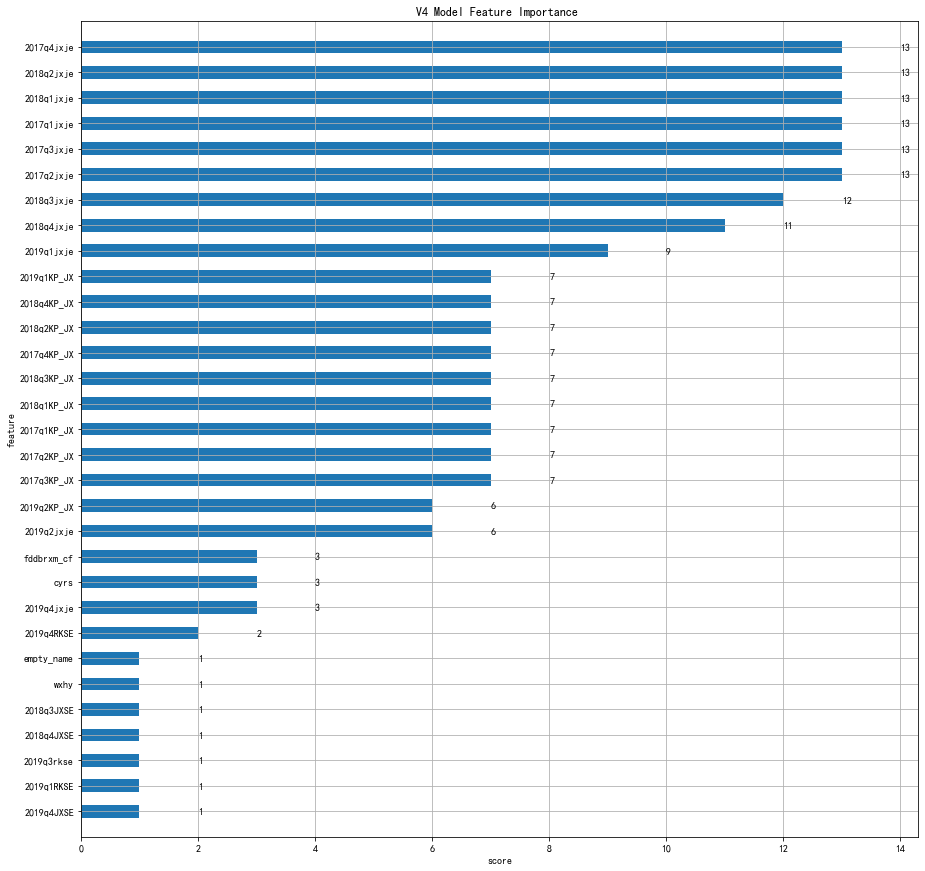

In [19]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15,15))
plot_importance(xgb_model,importance_type="weight", max_num_features = 64,
                height=0.5, ax = ax , title="V4 Model Feature Importance ",xlabel="score", ylabel="feature")
plt.show()

### 结论：提高了0.15分
`1.增加以上的6个重复情况特征，提高了0.5分，提升微弱。`<p>
`2.从特征重要性图可以看出，"注册地址重复情况"和"法定代表人姓名重复情况"特征的作用比较显著，下面删除其他特征测试效果`

In [20]:
## 重复出现： 0->yes

def extract_add_repeat_feature(data):
    ##办税人姓名重复
    #bsrxm = data["bsrxm"]
    #bsrxm_cf = bsrxm.duplicated()
    #data["bsrxm_cf"] = bsrxm_cf
    #
    ##办税人手机号重复
    #bsrxmmp = data["bsrxmmp"]
    #bsrxmmp_cf = bsrxmmp.duplicated()
    #data["bsrxmmp_cf"] = bsrxmmp_cf
    
    #法定代表人姓名重复
    fddbrxm = data["fddbrxm"]
    fddbrxm_cf = fddbrxm.duplicated()
    data["fddbrxm_cf"] = fddbrxm_cf
    
    ##法定代表人手机号重复
    #fdbrxmp = data["fdbrxmp"]
    #fdbrxmp_cf = fdbrxmp.duplicated()
    #data["fdbrxmp_cf"] = fdbrxmp_cf
    
    #zcdz:企业注册地址是否重复： 0->yes
    zcdz = data["zcdz"]
    zcdz_cf = zcdz.duplicated()
    data["zcdz_cf"] = zcdz_cf   
    
    ##scjydz_cf:生产经营地址是否重复： 0->yes
    #scjydz = data["scjydz"]
    #scjydz_cf = scjydz.duplicated()
    #data["scjydz_cf"] =  scjydz_cf
    
    return data

In [21]:
# 导入数据集 wuhu-md5-data
 
import wfio
_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

In [22]:
#第一步：读取数据
#df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')


#第二步：删除object类型的字段特征
#for f in df.columns:
#    if df[f].dtype == 'object':
#        df.drop(f, axis=1, inplace=True)
#        
#第三步：用0填充空值
df.fillna(0, inplace=True)
    
#划分训练集与测试集数据
label = df['yc']
feature = df.drop('yc', axis=1)

#增加税收特征
add_features = extract_shuiwu_feature(feature)

#增加高危行业特征
add_features = extract_gwhy_feature(add_features)

#增加地址重复的特征
add_features = extract_add_repeat_feature(add_features)

#删除object特征
for c_type in add_features.columns:
    if add_features[c_type].dtype == 'object':
        add_features.drop(c_type, axis = 1, inplace=True)
        
train_data, test_data ,train_label, test_label= train_test_split(add_features, label ,test_size=0.3, random_state = 20, shuffle=True)


In [23]:
train_data.shape

(1400, 198)

In [24]:
# 训练xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,         # 树的个数--1000棵树建立xgboost
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss'
                      )
xgb_model.fit(train_data, train_label)
y_pred  = xgb_model.predict(test_data)
score = get_score(xgb_model,test_label, test_data)
print("test set score :", score)

log_loss: 85.92225314871155
85.67962447521474
tr: 10
test set score : 87.11166202769327


### 结论："其他重复情况"字段删除后无影响
`1.从上面结果可以看出："生产经营地址重复情况"字段删除后，得分跟加上该特征的score结果相同都是89.35`

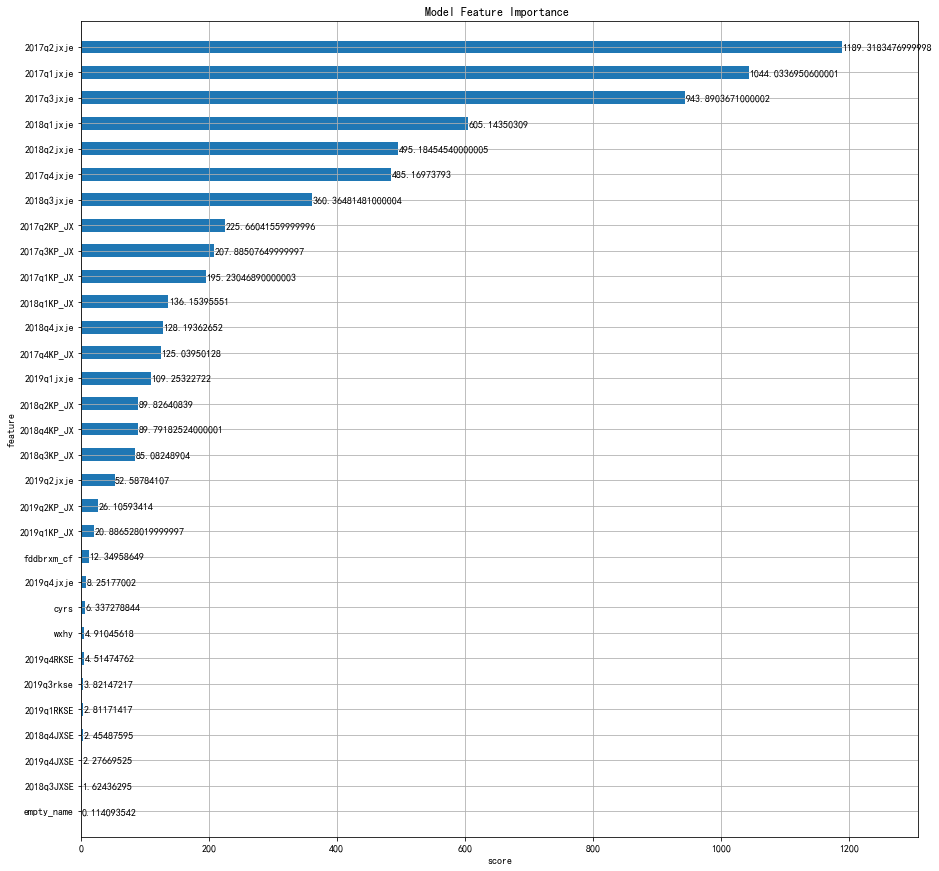

In [25]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15,15))
plot_importance(xgb_model,importance_type="total_gain", max_num_features = 64,
                height=0.5, ax = ax , title="Model Feature Importance ",xlabel="score", ylabel="feature")
plt.show()

### 决策树模型

In [26]:
from sklearn.tree import DecisionTreeClassifier
import joblib

tree = DecisionTreeClassifier(criterion="entropy",
                              splitter="best",
                              max_depth=24,
                              min_samples_split=2,
                              min_samples_leaf=1,
                              min_weight_fraction_leaf=0.,
                              max_features=None,
                              random_state=None,
                              # max_leaf_nodes=26,
                              min_impurity_decrease=0.,
                              min_impurity_split=None,
                              class_weight=None,
                              presort=False
                              )
tree.fit(train_data, train_label)
print('Train score:{:.3f}'.format(tree.score(train_data, train_label)))
print('Test score:{:.3f}'.format(tree.score(test_data, test_label)))
#joblib.dump(tree, 'tree.pkl')
print(get_score(tree,test_label, test_data))

Train score:0.986
Test score:0.968
log_loss: 236.04263822744855
60.659560295425244
tr: 10
64.59360426588272


#### 结论：决策树的模型效果不如XGBoost

## 公司名字异常:由于进行了md5加密处理，无法检测该生僻字，忽略这一部分的探索

In [27]:
import re
# 生僻字检测
def is_rare_name(string):
    risk=0
    
    #非法字符+生僻字
    pattern = re.compile(u"[~!@#$%^&* ]")
    match = pattern.search(string)
    if match:
        return True

    try:
        string.encode("gb2312")
        
    except UnicodeEncodeError:
        return True
    
    return False

In [28]:
## 导入数据集 wuhu-md5-data
# 
#import wfio
#_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
# 
## 读取并返回对应的Dataframe
## 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
#df = wfio.read_dataframe(_INPUT,as_spark = False)

In [29]:

##第一步：读取数据
##df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')
#
##第二步：检测生僻字
#i= 0
#label = []
#for i in  np.arange(0,df.shape[0]):
#    if is_rare_name(df["nsrmc"][i]):
#        label.append( df["yc"][i])
#
##可视化
#test = pd.DataFrame({"label":label})
#sns.countplot(x=test["label"]).set_title('Distribution of rare name label')

### 结论:生僻字中0与1基本平衡

### Xgboost模型

In [30]:
### 纳税人名称是否为生僻字： 0->yes
#def extract_rare_name_feature(data):
#    #检测生僻字
#    data['nsrmc_rare'] = data.apply(lambda x: is_rare_name(x["nsrmc"]), axis=1)
#    
#    return data

In [31]:
## 导入数据集 wuhu-md5-data
# 
#import wfio
#_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
# 
## 读取并返回对应的Dataframe
## 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
#df = wfio.read_dataframe(_INPUT,as_spark = False)

In [32]:
##第一步：读取数据
##df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')
#
#
##第二步：删除object类型的字段特征
##for f in df.columns:
##    if df[f].dtype == 'object':
##        df.drop(f, axis=1, inplace=True)
##        
##第三步：用0填充空值
#df.fillna(0, inplace=True)
#    
##划分训练集与测试集数据
#label = df['yc']
#feature = df.drop('yc', axis=1)
#
##增加税收特征
#add_features = extract_shuiwu_feature(feature)
#
##增加高危行业特征
#add_features = extract_gwhy_feature(add_features)
#
##增加地址重复的特征
#add_features = extract_add_repeat_feature(add_features)
#
##增加生僻字检测
#add_features = extract_rare_name_feature(add_features)
#
##删除object特征
#for c_type in add_features.columns:
#    if add_features[c_type].dtype == 'object':
#        add_features.drop(c_type, axis = 1, inplace=True)
#        
#train_data, test_data ,train_label, test_label= train_test_split(add_features, label ,test_size=0.3, random_state = 20, shuffle=True)
#

In [33]:
## 训练xgboost分类模型
#from xgboost import XGBClassifier
#xgb_model = XGBClassifier(learning_rate=0.1,
#                      n_estimators=20,         # 树的个数--1000棵树建立xgboost
#                      max_depth=10,              # 树的深度
#                      min_child_weight = 1,      # 叶子节点最小权重
#                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
#                      subsample=0.8,             # 随机选择80%样本建立决策树
#                      random_state=27,            # 随机数
#                      eval_metric='logloss'
#                      )
#xgb_model.fit(train_data, train_label)
#y_pred  = xgb_model.predict(test_data)
#score = get_score(xgb_model,test_label, test_data)
#print("test set score :", score)

#### 结论：加入纳税人名称生僻字检测字段后， 模型保持不变，未有任何的提升

## 增加登记日期距离现在的天数

In [34]:
#登记开业时间转数字
def exchange_date(data):
    
    def datestr2num(str):
        #2018/9/27
        try:
            str=str.split('/')
            str[2]=str[2].split(' ')[0]
            num=(2019-int(str[0]))*365+(12-int(str[1]))*30+(30-int(str[2]))
            return num
        except:
            return 0
    data['djrq'] = data.apply(lambda x:datestr2num(x["djrq"]), axis=1)
    
    return data

In [35]:
# 导入数据集 wuhu-md5-data
 
import wfio
_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

In [36]:
#第一步：读取数据
#df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')


#第二步：删除object类型的字段特征
#for f in df.columns:
#    if df[f].dtype == 'object':
#        df.drop(f, axis=1, inplace=True)
#        
#第三步：用0填充空值
df.fillna(0, inplace=True)
    
#划分训练集与测试集数据
label = df['yc']
feature = df.drop('yc', axis=1)


#增加税收特征
add_features = extract_shuiwu_feature(feature)

#增加高危行业特征
add_features = extract_gwhy_feature(add_features)

#增加地址重复的特征
add_features = extract_add_repeat_feature(add_features)

#增加生僻字检测
#add_features = extract_rare_name_feature(add_features)

#将登记日期转化为距离2019年12月31日的天数

add_features = exchange_date(add_features)


#删除object特征
for c_type in add_features.columns:
    if add_features[c_type].dtype == 'object':
        add_features.drop(c_type, axis = 1, inplace=True)
        
train_data, test_data ,train_label, test_label= train_test_split(add_features, label ,test_size=0.3, random_state = 20, shuffle=True)



In [37]:
train_data.shape

(1400, 199)

In [38]:
# 训练xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,         # 树的个数--100棵树建立xgboost
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss'
                      )

xgb_model.fit(train_data, train_label, verbose=True, eval_set=[(train_data, train_label),(test_data, test_label)])
y_pred  = xgb_model.predict(test_data)
score = get_score(xgb_model,test_label, test_data)
print("test set score :", score)

[0]	validation_0-logloss:0.60916	validation_1-logloss:0.61052
[1]	validation_0-logloss:0.54082	validation_1-logloss:0.54414
[2]	validation_0-logloss:0.48326	validation_1-logloss:0.48809
[3]	validation_0-logloss:0.43410	validation_1-logloss:0.44035
[4]	validation_0-logloss:0.39266	validation_1-logloss:0.40055
[5]	validation_0-logloss:0.35709	validation_1-logloss:0.36647
[6]	validation_0-logloss:0.32608	validation_1-logloss:0.33656
[7]	validation_0-logloss:0.29940	validation_1-logloss:0.31097
[8]	validation_0-logloss:0.27595	validation_1-logloss:0.28839
[9]	validation_0-logloss:0.25274	validation_1-logloss:0.26576
[10]	validation_0-logloss:0.23214	validation_1-logloss:0.24574
[11]	validation_0-logloss:0.21561	validation_1-logloss:0.23021
[12]	validation_0-logloss:0.19923	validation_1-logloss:0.21431
[13]	validation_0-logloss:0.18582	validation_1-logloss:0.20123
[14]	validation_0-logloss:0.17278	validation_1-logloss:0.18872
[15]	validation_0-logloss:0.16098	validation_1-logloss:0.17721
[1

### 结论：加入该特征得分降低

In [39]:
#获取训练过程logloss记录
evals_process= xgb_model.evals_result()

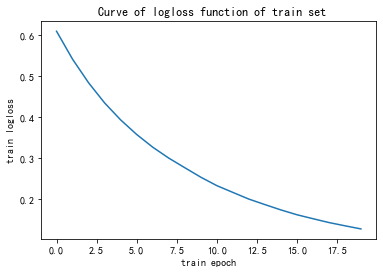

In [40]:
#绘制训练集集在训练过程中的loss曲线图

epoch = []  # 横坐标,迭代次数
for i in range(0, 20, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['validation_0']["logloss"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('train logloss')
plt.xlabel('train epoch')
plt.title(" Curve of logloss function of train set")
plt.show()

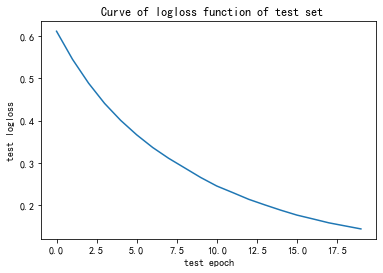

In [41]:
#绘制测试集在训练过程中的loss曲线图

epoch = []  # 横坐标,迭代次数
for i in range(0, 20, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['validation_1']["logloss"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('test logloss')
plt.xlabel('test epoch')
plt.title(" Curve of logloss function of test set")
plt.show()

### 从上图可知：当训练迭代次数为20时，logloss的值一直在下降，还未收敛，因此下面采用搜索最佳超参数来优化模型

## 超参搜索`整体搜索会会非常慢，因此分步搜索部分超参`

In [42]:
# 导入数据集 wuhu-md5-data
 
import wfio
_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

In [43]:
#第一步：读取数据
#df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')


#第二步：删除object类型的字段特征
#for f in df.columns:
#    if df[f].dtype == 'object':
#        df.drop(f, axis=1, inplace=True)
#        
#第三步：用0填充空值
df.fillna(0, inplace=True)
    
#划分训练集与测试集数据
label = df['yc']
feature = df.drop('yc', axis=1)


#增加税收特征
add_features = extract_shuiwu_feature(feature)

#增加高危行业特征
add_features = extract_gwhy_feature(add_features)

#增加地址重复的特征
add_features = extract_add_repeat_feature(add_features)

#增加生僻字检测，效果不佳删除该特征
#add_features = extract_rare_name_feature(add_features)

#将登记日期转化为距离2019年12月31日的天数,效果不佳删除该特征

#add_features = exchange_date(add_features)


#删除object特征
for c_type in add_features.columns:
    if add_features[c_type].dtype == 'object':
        add_features.drop(c_type, axis = 1, inplace=True)
        
train_data, test_data ,train_label, test_label= train_test_split(add_features, label ,test_size=0.3, random_state = 20, shuffle=True)


In [44]:
# 定义xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=20,         # 树的个数--20棵树建立xgboost
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss',
                      use_label_encoder = False
                      )

#### 首先搜索训练轮数

In [45]:
#首先搜索训练轮数
parameters = {
    #'max_depth': [5, 10, 15, 20, 25],
    #'learning_rate': [0.05, 0.1, 0.15],
    #'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'n_estimators': [50, 100, 200, 300],
    #'min_child_weight': [0, 2, 5, 10, 20],
    #'max_delta_step': [0, 0.2, 0.6, 1, 2],
    #'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
}

In [46]:
from sklearn.model_selection import GridSearchCV
gsearch = GridSearchCV(xgb_model, param_grid=parameters, scoring='neg_log_loss', cv=3)
gsearch.fit(train_data, train_label, verbose=True, eval_set=[(test_data, test_label)])

[0]	validation_0-logloss:0.61221
[1]	validation_0-logloss:0.54712
[2]	validation_0-logloss:0.49242
[3]	validation_0-logloss:0.44599
[4]	validation_0-logloss:0.40635
[5]	validation_0-logloss:0.37340
[6]	validation_0-logloss:0.34164
[7]	validation_0-logloss:0.31531
[8]	validation_0-logloss:0.29293
[9]	validation_0-logloss:0.27326
[10]	validation_0-logloss:0.25562
[11]	validation_0-logloss:0.23701
[12]	validation_0-logloss:0.22331
[13]	validation_0-logloss:0.21164
[14]	validation_0-logloss:0.19764
[15]	validation_0-logloss:0.18557
[16]	validation_0-logloss:0.17520
[17]	validation_0-logloss:0.16538
[18]	validation_0-logloss:0.15810
[19]	validation_0-logloss:0.15144
[20]	validation_0-logloss:0.14392
[21]	validation_0-logloss:0.13798
[22]	validation_0-logloss:0.13285
[23]	validation_0-logloss:0.12771
[24]	validation_0-logloss:0.12330
[25]	validation_0-logloss:0.12002
[26]	validation_0-logloss:0.11620
[27]	validation_0-logloss:0.11274
[28]	validation_0-logloss:0.10939
[29]	validation_0-loglos

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, mo...
                                     objective='binary:logistic',
                                     random_state=27, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=0.8, tree_method=None,


In [47]:
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.072
Best parameters set:
	n_estimators: 100


#### 结论：最佳迭代轮数为100

#### 接着搜索最佳学习率

In [48]:
#设置学习率
parameters = {
    #'max_depth': [5, 10, 15, 20, 25],
    'learning_rate': [0.01, 0.02,0.05, 0.1, 0.15],
    #'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    #'n_estimators': [50, 100, 200, 300],
    #'min_child_weight': [0, 2, 5, 10, 20],
    #'max_delta_step': [0, 0.2, 0.6, 1, 2],
    #'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
}

In [49]:
# 定义xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,
                      n_estimators=100,         # 100棵树建立xgboost模型最佳
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss',
                      use_label_encoder = False
                      )

In [50]:
from sklearn.model_selection import GridSearchCV
gsearch = GridSearchCV(xgb_model, param_grid=parameters, scoring='neg_log_loss', cv=3)
gsearch.fit(train_data, train_label, verbose=True, eval_set=[(test_data, test_label)])

[0]	validation_0-logloss:0.68468
[1]	validation_0-logloss:0.67656
[2]	validation_0-logloss:0.66860
[3]	validation_0-logloss:0.66073
[4]	validation_0-logloss:0.65300
[5]	validation_0-logloss:0.64563
[6]	validation_0-logloss:0.63828
[7]	validation_0-logloss:0.63091
[8]	validation_0-logloss:0.62389
[9]	validation_0-logloss:0.61691
[10]	validation_0-logloss:0.60999
[11]	validation_0-logloss:0.60317
[12]	validation_0-logloss:0.59655
[13]	validation_0-logloss:0.59006
[14]	validation_0-logloss:0.58369
[15]	validation_0-logloss:0.57742
[16]	validation_0-logloss:0.57117
[17]	validation_0-logloss:0.56501
[18]	validation_0-logloss:0.55893
[19]	validation_0-logloss:0.55299
[20]	validation_0-logloss:0.54723
[21]	validation_0-logloss:0.54150
[22]	validation_0-logloss:0.53577
[23]	validation_0-logloss:0.53018
[24]	validation_0-logloss:0.52463
[25]	validation_0-logloss:0.51933
[26]	validation_0-logloss:0.51416
[27]	validation_0-logloss:0.50897
[28]	validation_0-logloss:0.50398
[29]	validation_0-loglos

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='logloss', gamma=0.0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=10, min_child_weight=1,
                                     missing=nan, mo...
                                     objective='binary:logistic',
                                     random_state=27, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=0.8, tree_method=None,


In [51]:
print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.072
Best parameters set:
	learning_rate: 0.1


#### 结论：learn_rate设置为0.1为最佳值

#### 搜索树的深度

In [52]:
#再搜索树的深度
parameters = {
    'max_depth': [5, 10, 15, 20, 25],
    #'learning_rate': [0.01, 0.02,0.05, 0.1, 0.15],
    #'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    #'n_estimators': [50, 100, 200, 300],
    #'min_child_weight': [0, 2, 5, 10, 20],
    #'max_delta_step': [0, 0.2, 0.6, 1, 2],
    #'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
}

# 定义xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,    #0.1为最佳学习率
                      n_estimators=100,         # 100棵树建立xgboost模型最佳
                      max_depth=10,              # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss',
                      use_label_encoder = False
                      )

from sklearn.model_selection import GridSearchCV
gsearch = GridSearchCV(xgb_model, param_grid=parameters, scoring='neg_log_loss', cv=3)
gsearch.fit(train_data, train_label, verbose=True, eval_set=[(test_data, test_label)])

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[0]	validation_0-logloss:0.62604
[1]	validation_0-logloss:0.57008
[2]	validation_0-logloss:0.52394
[3]	validation_0-logloss:0.48176
[4]	validation_0-logloss:0.44631
[5]	validation_0-logloss:0.41813
[6]	validation_0-logloss:0.38889
[7]	validation_0-logloss:0.36447
[8]	validation_0-logloss:0.34263
[9]	validation_0-logloss:0.32270
[10]	validation_0-logloss:0.30480
[11]	validation_0-logloss:0.28885
[12]	validation_0-logloss:0.27350
[13]	validation_0-logloss:0.25961
[14]	validation_0-logloss:0.24759
[15]	validation_0-logloss:0.23646
[16]	validation_0-logloss:0.22603
[17]	validation_0-logloss:0.21649
[18]	validation_0-logloss:0.20769
[19]	validation_0-logloss:0.19924
[20]	validation_0-logloss:0.19183
[21]	validation_0-logloss:0.18483
[22]	validation_0-logloss:0.17818
[23]	validation_0-logloss:0.17195
[24]	validation_0-logloss:0.16595
[25]	validation_0-logloss:0.16099
[26]	validation_0-logloss:0.15639
[27]	validation_0-logloss:0.15213
[28]	validation_0-logloss:0.14824
[29]	validation_0-loglos

#### 结论：10为树深度最佳值

#### 搜索建树的占比

In [53]:
#设置建树的占比
parameters = {
    #'max_depth': [5, 10, 15, 20, 25],
    #'learning_rate': [0.01, 0.02,0.05, 0.1, 0.15],
    #'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5],
    #'n_estimators': [50, 100, 200, 300],
    #'min_child_weight': [0, 2, 5, 10, 20],
    #'max_delta_step': [0, 0.2, 0.6, 1, 2],
    'subsample': [0.6, 0.7, 0.8, 0.85, 0.95],
}

# 定义xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,    #0.1为最佳学习率
                      n_estimators=100,         # 100棵树建立xgboost模型最佳
                      max_depth=10,              # 5为树深度最佳取值
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss',
                      use_label_encoder = False
                      )

from sklearn.model_selection import GridSearchCV
gsearch = GridSearchCV(xgb_model, param_grid=parameters, scoring='neg_log_loss', cv=3)
gsearch.fit(train_data, train_label, verbose=True, eval_set=[(test_data, test_label)])

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

[0]	validation_0-logloss:0.61413
[1]	validation_0-logloss:0.54954
[2]	validation_0-logloss:0.49589
[3]	validation_0-logloss:0.45037
[4]	validation_0-logloss:0.41102
[5]	validation_0-logloss:0.37711
[6]	validation_0-logloss:0.34858
[7]	validation_0-logloss:0.32372
[8]	validation_0-logloss:0.30000
[9]	validation_0-logloss:0.28040
[10]	validation_0-logloss:0.26069
[11]	validation_0-logloss:0.24400
[12]	validation_0-logloss:0.22861
[13]	validation_0-logloss:0.21558
[14]	validation_0-logloss:0.20411
[15]	validation_0-logloss:0.19282
[16]	validation_0-logloss:0.18403
[17]	validation_0-logloss:0.17443
[18]	validation_0-logloss:0.16657
[19]	validation_0-logloss:0.15959
[20]	validation_0-logloss:0.15266
[21]	validation_0-logloss:0.14688
[22]	validation_0-logloss:0.14019
[23]	validation_0-logloss:0.13527
[24]	validation_0-logloss:0.13036
[25]	validation_0-logloss:0.12640
[26]	validation_0-logloss:0.12296
[27]	validation_0-logloss:0.11930
[28]	validation_0-logloss:0.11589
[29]	validation_0-loglos

#### 结论:建树占比的最佳值为0.95

#### 使用最佳超参数训练模型

In [54]:
# 导入数据集 wuhu-md5-data
 
import wfio
_INPUT = '{"type":15,"uri":"awss3534406d570ec4c3facb58eccca0a5fbf/sd_2867f74f48b7400ab627b5446b34c004"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
df = wfio.read_dataframe(_INPUT,as_spark = False)

In [55]:
#第一步：读取数据
#df = pd.read_csv("./origin_dataset/train.csv", encoding='GBK')


#第二步：删除object类型的字段特征
#for f in df.columns:
#    if df[f].dtype == 'object':
#        df.drop(f, axis=1, inplace=True)
#        
#第三步：用0填充空值
df.fillna(0, inplace=True)
    
#划分训练集与测试集数据
label = df['yc']
feature = df.drop('yc', axis=1)

#增加税收特征
add_features = extract_shuiwu_feature(feature)

#增加高危行业特征
add_features = extract_gwhy_feature(add_features)

#增加地址重复的特征
add_features = extract_add_repeat_feature(add_features)

#删除object特征
for c_type in add_features.columns:
    if add_features[c_type].dtype == 'object':
        add_features.drop(c_type, axis = 1, inplace=True)
        
train_data, test_data ,train_label, test_label= train_test_split(add_features, label ,test_size=0.3, random_state = 20, shuffle=True)

In [56]:
# 训练xgboost分类模型
from xgboost import XGBClassifier
xgb_model = XGBClassifier(learning_rate=0.1,    #0.1为最佳学习率
                      n_estimators=100,         # 100棵树建立xgboost模型最佳
                      max_depth=10,              # 5为树深度最佳取值
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.95,             # 随机选择80%样本建立决策树
                      random_state=27,            # 随机数
                      eval_metric='logloss',
                      use_label_encoder = False
                      )
xgb_model.fit(train_data, train_label, verbose=True, eval_set=[(train_data, train_label),(test_data, test_label)])
y_pred  = xgb_model.predict(test_data)
score = get_score(xgb_model,test_label, test_data)
print("test set score :", score)

[0]	validation_0-logloss:0.60845	validation_1-logloss:0.61023
[1]	validation_0-logloss:0.53958	validation_1-logloss:0.54319
[2]	validation_0-logloss:0.48196	validation_1-logloss:0.48703
[3]	validation_0-logloss:0.43306	validation_1-logloss:0.43943
[4]	validation_0-logloss:0.39116	validation_1-logloss:0.39904
[5]	validation_0-logloss:0.35550	validation_1-logloss:0.36471
[6]	validation_0-logloss:0.32477	validation_1-logloss:0.33484
[7]	validation_0-logloss:0.29789	validation_1-logloss:0.30928
[8]	validation_0-logloss:0.27448	validation_1-logloss:0.28727
[9]	validation_0-logloss:0.25391	validation_1-logloss:0.26777
[10]	validation_0-logloss:0.23237	validation_1-logloss:0.24662
[11]	validation_0-logloss:0.21357	validation_1-logloss:0.22819
[12]	validation_0-logloss:0.19942	validation_1-logloss:0.21453
[13]	validation_0-logloss:0.18441	validation_1-logloss:0.19967
[14]	validation_0-logloss:0.17113	validation_1-logloss:0.18670
[15]	validation_0-logloss:0.16095	validation_1-logloss:0.17716
[1

#### 结论：最佳超参训练出来的模型score值为95.77

In [57]:
#获取训练过程logloss记录
evals_process= xgb_model.evals_result()

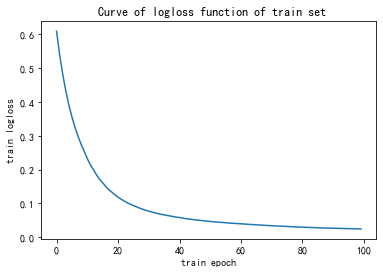

In [58]:
#绘制训练集集在训练过程中的loss曲线图

epoch = []  # 横坐标,迭代次数
for i in range(0, 100, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['validation_0']["logloss"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('train logloss')
plt.xlabel('train epoch')
plt.title(" Curve of logloss function of train set")
plt.show()

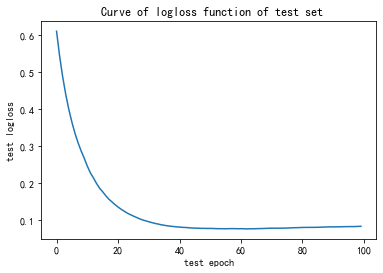

In [59]:
#绘制测试集在训练过程中的loss曲线图

epoch = []  # 横坐标,迭代次数
for i in range(0, 100, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['validation_1']["logloss"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('test logloss')
plt.xlabel('test epoch')
plt.title(" Curve of logloss function of test set")
plt.show()

## 全量运行时的结果保存

In [60]:
#导入包
from wf_analyse.analyse import base

In [64]:
#score打分
base.save_norm(model_name='best_model', norm_name='mse',norm_value=np.float(score), operate_type='train')       

norm validate success,begin saving...
access token is None, skipping transforming.


In [65]:
#保存训练集在训练过程中的loss值，用于绘制loss变化曲线图
n_estimators = 100
for i in range(0, n_estimators, 1):
    base.save_norm_by_step(model_name='train', norm_name='loss',norm_value=np.float(evals_process['validation_0']["logloss"][i]),step=i)
    #print(evals_process['test']["rmse"][i]

norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

In [66]:
#保存测试集在训练过程中的loss值，用于绘制loss变化曲线图
n_estimators = 100
for i in range(0, n_estimators, 1):
    base.save_norm_by_step(model_name='validation', norm_name='loss',norm_value=np.float(evals_process['validation_1']["logloss"][i]),step=i)
    #print(evals_process['test']["rmse"][i]

norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm